In [2]:
%run ../demos/qsu.ipynb  # color-printing functions
import numpy as np
from qecsim import paulitools as pt
from qecsim.models.generic import INIDErrorModel
from qecsim.models.rotatedplanar import RotatedPlanarCode, RotatedPlanarMWPMDecoder
from qecsim import graphtools as gt
from scipy.spatial import distance


# set random seed for reproducibility
rng = np.random.default_rng(16)

# initialise models
rotated_planar_code = RotatedPlanarCode(5, 5)
my_code = rotated_planar_code

t = 1e-6
T_1 = rng.random(my_code.n_k_d[0])*1e-4
T_2 = rng.random(my_code.n_k_d[0])*1e-4

my_error_model = INIDErrorModel(T_1, T_2)
my_decoder = RotatedPlanarMWPMDecoder()
# print models
print(my_code)
print(my_error_model)
print(my_decoder)

# sample a random error
error = my_error_model.generate(rotated_planar_code, t=t, rng=rng)
qsu.print_pauli(rotated_planar_code.new_pauli(error))

# get the syndrome corresponding to the sampled error. Syndrome: stabilizers that do not commute with the error
syndrome = pt.bsp(error, rotated_planar_code.stabilizers.T)
qsu.print_pauli('syndrome:\n{}'.format(my_code.ascii_art(syndrome)))

# get the plaquette indices for the syndrome and split into X and Z type plaquettes
x_syndrome, z_syndrome = [], []
for plaquette_index in rotated_planar_code.syndrome_to_plaquette_indices(syndrome):
    x_syndrome.append(plaquette_index) if rotated_planar_code.is_x_plaquette(plaquette_index) else z_syndrome.append(plaquette_index)

ValueError: The condition T_2 <= 2*T_1 should be satisfied for all qubits to ensure that there are no negative probabilities.

[4.0464342  3.77451455 2.29417373 3.5641761  4.13759951 0.99467539
 4.47692981 4.45325285 1.59922897 4.39127294 2.94359786 4.24940325
 2.77292626 4.24367192 4.56813531 4.59511323 4.2021638  2.82517584
 3.68870881 3.34295081 4.56505462 3.41566851 4.03617125 3.71937411
 2.66575222]
[3.66295421 4.34953687 3.73437731 4.22585057 4.07221517 2.0996246
 4.29714427 4.21801898 4.39066811 2.73428572 4.58446498 4.46896454
 4.50874637 4.57156557 4.13705665 3.62754263 1.8422793  4.25363252
 4.15356451 4.18059821 0.2492907  4.55460486 3.6688623  2.01983527
 4.59936476]


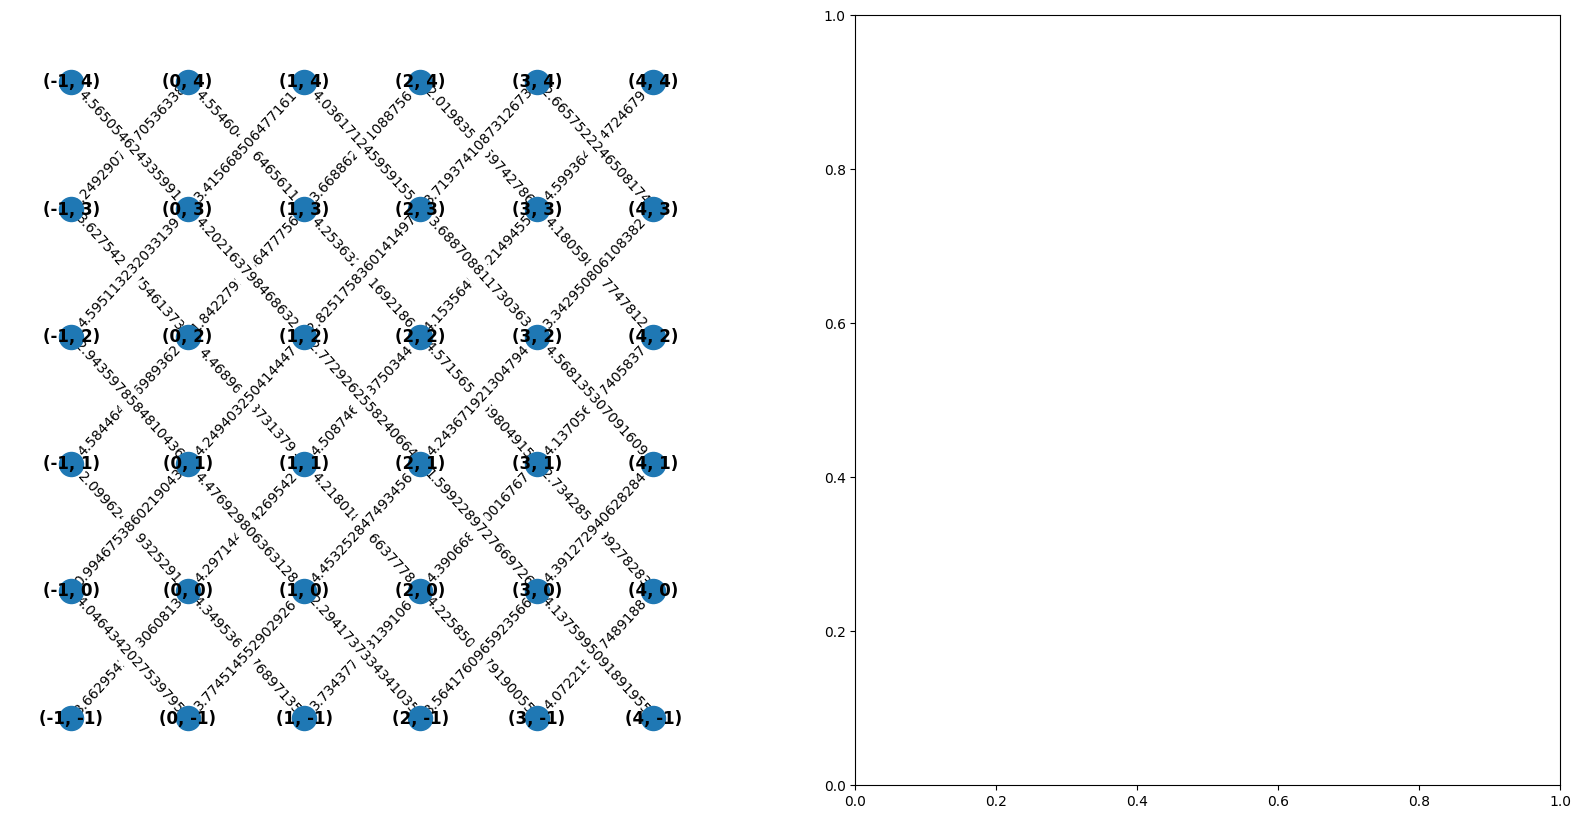

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import itertools

def create_check_graphs(code, t, T_1, T_2):
    """
    Create the graphs for the X-checks and Z-checks (see Fig. 6 of https://arxiv.org/pdf/2307.14989.pdf%C3%A7). 
    The edges conncect neighboring plaquettes of the same type and they resemble the qubits between them.
    The weights of the edges are determined by the T_1 and T_2 times of the corresponding qubits.
    
    :param code: RotatedPlanarCode
    :type code: RotatedPlanarCode
    :param plaquettes: list of plaquette indices
    :type plaquettes: list of 2-tuple of int
    :return: graph of checks
    :rtype: nx.Graph
    """
    # create a list of all the plaquettes and virtual plaquettes for x and z
    plaquette_indices = code._plaquette_indices
    virtual_z_plaquettes, virtual_x_plaquettes = code._virtual_plaquette_indices
    z_plaquettes = [index for index in plaquette_indices if code.is_z_plaquette(index)] + virtual_z_plaquettes
    x_plaquettes = [index for index in plaquette_indices if code.is_x_plaquette(index)] + virtual_x_plaquettes
    
    # define the weights of each qubit based on the T_1 and T_2 times
    # TODO: Ask Ton
    weight_T_1 = np.abs(np.log(1-np.exp(-t/T_1)))
    print(weight_T_1)
    weight_T_2 = np.abs(np.log(1-np.exp(-t/T_2)))
    print(weight_T_2)
    
    # create the graphs for x and z checks: see row 2 in Fig. 6 of https://arxiv.org/pdf/2307.14989.pdf%C3%A7
    g_x = nx.Graph()
    g_z = nx.Graph()
    max_site_x, max_site_y = code.site_bounds
    for y in range(-1, max_site_y+1):
        for x in range(-1, max_site_x+1):
            index = (x, y) # current plaquette
            left_up = (x-1, y+1) # plaquette one step up and one step left from the current plaquette
            right_up = (x+1, y+1) # plaquette one step up and one step right from the current plaquette
            if index in x_plaquettes:
                if left_up in x_plaquettes:
                    qubit_number = x + (y+1)*(max_site_x+1)
                    g_x.add_edge(index, left_up, qubit_index=(x,y+1), qubit_number=qubit_number, weight=weight_T_1[qubit_number])
                if right_up in x_plaquettes: 
                    qubit_number = right_up[0] + right_up[1]*(max_site_x+1)
                    g_x.add_edge(index, right_up, qubit_index=right_up, qubit_number=qubit_number, weight=weight_T_1[qubit_number])
                    
            elif index in z_plaquettes:
                if left_up in z_plaquettes:
                    qubit_number = x + (y+1)*(max_site_x+1) 
                    g_z.add_edge(index, left_up, qubit_index=(x,y+1), qubit_number=qubit_number, weight=weight_T_2[qubit_number])
                if right_up in z_plaquettes:
                    qubit_number = right_up[0] + right_up[1]*(max_site_x+1)
                    g_z.add_edge(index, right_up, qubit_index=right_up, qubit_number=qubit_number, weight=weight_T_2[qubit_number])
    return g_z, g_x

G_z, G_x = create_check_graphs(rotated_planar_code, t, T_1, T_2)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))           
positions_z = {v: v for v in G_z.nodes()}
nx.draw(G_z, ax=ax[0], pos=positions_z, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G_z, ax=ax[0], pos=positions_z, edge_labels=nx.get_edge_attributes(G_z, 'weight'))

positions_x = {v: v for v in G_x.nodes()}
nx.draw(G_x, ax=ax[0], pos=positions_x, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G_x, ax=ax[0], pos=positions_x, edge_labels=nx.get_edge_attributes(G_x, 'weight'))

plt.show()

In [ ]:
print(G_z.edges[(-1, -1), (0, 0)])

path = nx.dijkstra_path_length(G_z, (-1, -1), (3, 3))
print(path)

{'qubit_index': (0, 0), 'qubit_number': 0, 'weight': 3.6629542083060813}
16.62240937054091


In [5]:
t = 1e-6

# T2 <= 2*T1
_T_1 = 1e-4#np.random.random()*1e-4
_T_2 = 2.01*_T_1#np.random.random()*1e-4

# for each qubit n, calculate the probability of each Pauli error
p_x1 = 1/4 * (1 - np.exp(-t / _T_1))
p_y1 = p_x1
p_z1 = 1/4 * (1 + np.exp(-t / _T_1) - 2*np.exp(-t / _T_2))
p_i1 = 1 - p_x1 - p_y1 - p_z1


gamma = 1 - np.exp(-t / _T_1)
lambda_ = 1 - np.exp(-2*t / _T_2)
p_x2 = gamma / 4
p_y2 = p_x2
p_z2 = (2 - gamma - 2*np.sqrt( 1 - gamma - (1-gamma)*lambda_ )) / 4
p_i2 = 1 - p_x2 - p_y2 - p_z2
        
print(p_x1, p_y1, p_z1, p_i1, sum([p_x1, p_y1, p_z1, p_i1]))
print(p_x2, p_y2, p_z2, p_i2, sum([p_x2, p_y2, p_z2, p_i2]))





0.0024875415627079733 0.0024875415627079733 -6.1570900823926245e-06 0.9950310739646666 1.0000000000000002
0.0024875415627079733 0.0024875415627079733 0.002475227356888321 0.9925496895176958 1.0


In [ ]:
print(_T_1, _T_2)

2.8846547294869642e-05 9.560620259772037e-05
